In [1]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, f1_score, mean_absolute_percentage_error, mean_absolute_error
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# hyperparameters
split = (0.85);
sequence_length = 10;
epochs = 15
learning_rate = 0.01

## FinBERT Sentiment

This time, we load the FinBERT and VADER Sentiment Analysis.

In [3]:

# loading stock price and news data
stock_data = pd.read_csv("data/price.csv")
news_data = pd.read_csv("data/news_w_sentiment2.csv")

## Data Preprocessing

This code prepares training and testing data for a financial prediction model that combines historical stock prices with news sentiment analysis. It:

1. Extracts S&P 500 (SPX) data and selects closing prices and sentiment scores as features
2. Splits data into training and testing sets based on a predefined ratio
3. Normalizes the stock price data using MinMaxScaler to standardize the range
4. Creates sequence data for time series prediction:
    * Each input sequence contains sequence_length consecutive stock prices
    * Each target value is the next price after the sequence* 
5. Enriches the data by adding sentiment information:
    * Appends the corresponding news sentiment score to each sequence
    * Handles edge cases where sentiment data might be missing
    * Uses the most recent sentiment when necessary
6. Converts all data to properly formatted numpy arrays with float type

The results is training and testing datasets where each input contains both historical price sequences and sentiment information, allowing the model to leverage both technical and sentiment factors for prediction.

In [4]:

# news_data['FinBERT score'] = news_data['positive'] - news_data['negative']

sp = stock_data[stock_data['ticker'] == 'SPX']
stock_column = ['close']
news_column = ['combined_sentiment']

len_stock_data = sp.shape[0]

# splitting data to train and test
train_examples = int(len_stock_data * split)
train = sp.get(stock_column).values[:train_examples]
train_sentiment = news_data.get(news_column).values[:train_examples]
test = sp.get(stock_column).values[train_examples:]
test_sentiment = news_data.get(news_column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]
len_train_sentiment = train_sentiment.shape[0]
len_test_sentiment = test_sentiment.shape[0]


# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)


# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
len_X_train = len(X_train)
y_train = np.array(train[sequence_length:]).astype(float)


# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
len_X_test = len(X_test)
y_test = np.array(test[sequence_length:]).astype(float)


# adding news sentiment to train and test
for i in range(len_X_train):
    X_train[i] = X_train[i].tolist()
    # Check if we have sentiment data
    if len_train_sentiment > 0:
        if i + sequence_length < len_train_sentiment:
            X_train[i].append(train_sentiment[i + sequence_length].tolist())
        else:
            # If we're at the end, use the last available sentiment
            X_train[i].append(train_sentiment[-1].tolist())
    else:
        # If no sentiment data, append 0
        X_train[i].append([0.0])
X_train = np.array(X_train).astype(float)

for i in range(len_X_test):
    X_test[i] = X_test[i].tolist()
    # Check if we have sentiment data
    if len_test_sentiment > 0:
        if i + sequence_length < len_test_sentiment:
            X_test[i].append(test_sentiment[i + sequence_length].tolist())
        else:
            # If we're at the end, use the last available sentiment
            X_test[i].append(test_sentiment[-1].tolist())
    else:
        # If no sentiment data, append 0
        X_test[i].append([0.0])
X_test = np.array(X_test).astype(float)


In [5]:

def calculate_r2(y_true, y_pred, in_sample=True, benchmark=None):
    if in_sample:
        return 1 - (np.sum((y_true - y_pred) ** 2) / 
                    np.sum((y_true - np.mean(y_true)) ** 2))
    else:
        if benchmark is None:
            raise ValueError("Benchmark must be provided for out-of-sample R-squared calculation.")
        return 1 - (np.sum((y_true - y_pred) ** 2) / 
                    np.sum((y_true - benchmark) ** 2))

## Modeling

This model is a stacked LSTM architecture for financial time series prediction that incorporates both historical stock prices and FinBERT-generated sentiment data:

1. Model Architecture:
* Three sequential LSTM layers (50, 30, 20 units) with tanh activation
* Final dense layer with linear activation for price prediction
* Takes input sequences of shape (sequence_length+1, 1)
2. FinBERT Sentiment Integration:
* From the previous code snippet, we can see that FinBERT sentiment scores from financial news ("combined_sentiment") are appended to each price sequence
* Each input sequence contains both historical closing prices AND the corresponding news sentiment
* This allows the model to incorporate market sentiment as an additional predictive feature
3. Training Approach:
* Creates a manual validation split (20%) from the training data
* Uses MSE loss with Adam optimizer
* Inverse transforms predictions back to original price scale

The key innovation is that the model can simultaneously process both technical data (price sequences) and fundamental/sentiment data (FinBERT scores). This multi-modal approach potentially allows the model to capture both price momentum and market sentiment effects for more accurate predictions.

In [6]:
#creating LSTM model
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 50, activation = "tanh", return_sequences = True),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.LSTM(units = 20, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    )

    # Split training data into training and validation sets (80-20 split)
    val_split = 0.2
    val_size = int(len(X_train) * val_split)
    
    X_val = X_train[-val_size:]
    y_val = y_train[-val_size:]
    X_train_new = X_train[:-val_size]
    y_train_new = y_train[:-val_size]

    # Train the model with validation data
    history = model.fit(
        X_train_new, y_train_new,
        validation_data=(X_val, y_val),
        epochs = epochs,
        verbose=1
    )
    
    return model, history

#%%

# inverting normaliztion
y_test = scaler.inverse_transform(y_test)

## Model Evaluation

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0296 - val_loss: 0.0089
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - val_loss: 0.0105
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 9/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 10/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 11/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 12/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010 - val_l

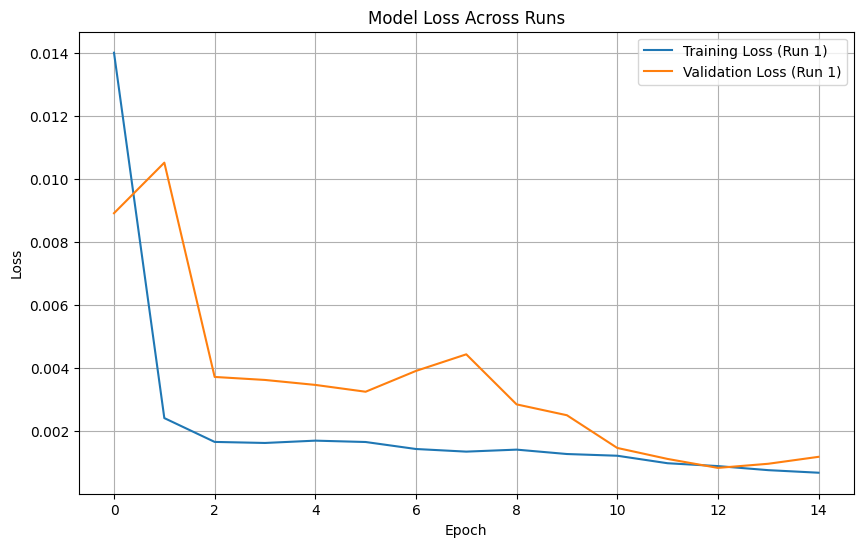

In [7]:

# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
    return predictions



# evaluation
def evaluate(predictions):
    # Existing metrics
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    r2 = calculate_r2(y_test, predictions, in_sample=False, benchmark=0)
    
    # Convert predictions and actual values to binary classes (1 for increase, 0 for decrease)
    y_pred_binary = np.where(np.diff(predictions.flatten()) > 0, 1, 0)
    y_true_binary = np.where(np.diff(y_test.flatten()) > 0, 1, 0)
    
    # Calculate F1 score
    f1 = f1_score(y_true_binary, y_pred_binary)
    
    return mae, mape, (1 - mape), r2, f1

# trial runs
def run_model(n):
    total_mae = total_mape = total_acc = total_r2 = total_f1 = 0
    histories = []
    global predictions
    for i in range(n):
        model, history = model_create()
        predictions = predict(model)
        mae, mape, acc, r2, f1 = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc
        total_r2 += r2
        total_f1 += f1
        histories.append(history)
    return (total_mae / n), (total_mape / n), (total_acc / n), (total_r2 / n), (total_f1 / n), histories

# Run the model and get the histories
mae, mape, acc, r2, f1, histories = run_model(1)

print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")
print(f"R-squared = {r2}")
print(f"F1 Score = {f1}")
# Plot the final training and validation loss
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Training Loss (Run {i+1})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (Run {i+1})')
plt.title('Model Loss Across Runs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
# %%